In [1]:
import warnings
warnings.filterwarnings('ignore')
import json

from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import transpile, schedule, assemble
from qiskit.tools.monitor import job_monitor

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.optimize import curve_fit

In [2]:
import sys
sys.path.insert(0, '../..')
from utils.circuit_utils import get_closest_multiple_of, get_closest_multiple_of_16
from utils.job_utils import get_job_data, save_job, load_job
from utils.result_utils import baseline_remove, fit_function, single_qubit_count
from utils.higher_energy_states.pulse_gate import Sched
from utils.higher_energy_states.state_prep import gen_circ

In [3]:
with open(r"../provider.json", "r") as f:
    credential = json.load(f)

IBMQ.load_account()
provider = IBMQ.get_provider(hub = credential["hub"], group = credential["group"], project = credential["project"])
backend = provider.get_backend("ibm_lagos")

# Calibration Data from IBM

In [3]:
from qiskit.tools.jupyter import *

backend_defaults = backend.defaults()

backend_properties = backend.properties()

num_qubit = backend.configuration().n_qubits

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

for qubit in range(num_qubit):
    default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
    print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

    default_anharmonicity = backend_properties.qubits[qubit][3].value # Default anharmonicity in GHz
    print(f"Default anharmonicity is {default_anharmonicity} GHz.")
    print()

default_qubit_freq_list = [backend_defaults.qubit_freq_est[qubit] for qubit in range(num_qubit)]
anharm_12_list = [backend_properties.qubits[qubit][3].value * GHz for qubit in range(num_qubit)]

# scale data (specific to each device)
scale_factor = 1e-7

# number of shots for our experiments
NUM_SHOTS = 1024

Qubit 0 has an estimated frequency of 5.235356607259804 GHz.
Default anharmonicity is -0.33986713855915607 GHz.

Qubit 1 has an estimated frequency of 5.099657727973357 GHz.
Default anharmonicity is -0.3432484042938357 GHz.

Qubit 2 has an estimated frequency of 5.188302032817194 GHz.
Default anharmonicity is -0.3419316690031256 GHz.

Qubit 3 has an estimated frequency of 4.987465741341958 GHz.
Default anharmonicity is -0.3452928861203798 GHz.

Qubit 4 has an estimated frequency of 5.285363831274846 GHz.
Default anharmonicity is -0.3392342674107948 GHz.

Qubit 5 has an estimated frequency of 5.1760937303719965 GHz.
Default anharmonicity is -0.34079297245074963 GHz.

Qubit 6 has an estimated frequency of 5.063901324153617 GHz.
Default anharmonicity is -0.34275836537159754 GHz.



In [6]:
print("1->2 Pi pulse Frequencies:")

for qubit in range(num_qubit):
    print(f"Qubit {qubit}: {backend_defaults.qubit_freq_est[qubit] + backend_properties.qubits[qubit][3].value*GHz} HZ")

1->2 Pi pulse Frequencies:
Qubit 0: 4895489468.700647 HZ
Qubit 1: 4756409323.679522 HZ
Qubit 2: 4846370363.814069 HZ
Qubit 3: 4642172855.221579 HZ
Qubit 4: 4946129563.864051 HZ
Qubit 5: 4835300757.9212475 HZ
Qubit 6: 4721142958.78202 HZ


# Measure 1 -> 2 frequency

In [6]:
# smaller range sweep
num_freqs = 200
drive_power = 0.15
sweep_freqs = np.linspace(-30*MHz, 30*MHz, num_freqs)

# there are pulse parameters of the single qubit drive in IBM devices
x12_duration = 160
x12_sigma = 40

In [7]:
freq_sweep_12_list = []
freq12_sweep_sched_list = []
for qubit in range(num_qubit):
    freq_sweep_12 = Parameter(f'freq_sweep_12_{qubit}')
    freq_sweep_12_list.append(freq_sweep_12)
    with pulse.build(backend=backend, default_alignment='sequential', name=f'Frequency sweep 12 {qubit}') as freq12_sweep_sched:
        drive_chan = pulse.drive_channel(qubit)
        with pulse.frequency_offset(freq_sweep_12, drive_chan):
            pulse.play(pulse.Gaussian(duration=x12_duration,
                                      amp=drive_power,
                                      sigma=x12_sigma,
                                      name='x12_pulse'), drive_chan)
    freq12_sweep_sched_list.append(freq12_sweep_sched)

In [8]:
qubit_list = list(range(num_qubit))

qc_spect = QuantumCircuit(num_qubit)

for qubit in qubit_list:
    spect_gate = Gate("spect", 1, [freq_sweep_12_list[qubit]])
    qc_spect.append(spect_gate, [qubit])
    qc_spect.add_calibration(spect_gate, (qubit, ), freq12_sweep_sched_list[qubit], [freq_sweep_12_list[qubit]])
    
qc_spect.measure_all()
    
exp_spect_circs = [qc_spect.assign_parameters({freq_sweep_12_list[qubit]: f for qubit in qubit_list}) for f in sweep_freqs]

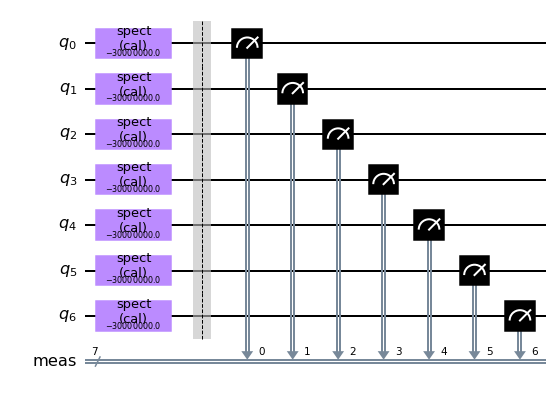

In [12]:
exp_spect_circs[0].draw()

In [13]:
# freq_12_sweep_job = backend.run(exp_spect_circs, 
#                                      meas_level=1, 
#                                      meas_return='avg', 
#                                      shots=NUM_SHOTS)
# freq_12_sweep_job.job_id()

'63f62ed93c908086bc8f4573'

In [7]:
# freq_12_sweep_job = backend.retrieve_job('63f62ed93c908086bc8f4573')

In [14]:
# save_job(freq_12_sweep_job, filename='data/freq_12_sweep_job.pickle')

In [10]:
# freq_12_sweep_job = load_job(filename='data/freq_12_sweep_job.pickle')

In [10]:
# from qiskit.tools.monitor import job_monitor

# job_monitor(freq_12_sweep_job)

Job Status: job has successfully run


In [91]:
# # Get the refined data (average)
# freq_12_sweep_data = get_job_data(freq_12_sweep_job, average=True, scale_factor=scale_factor)
# freq_12_sweep = np.array(default_qubit_freq_list).reshape((7, 1)) + np.array(anharm_12_list).reshape((7, 1)) + sweep_freqs
# save_job(freq_12_sweep_data, filename='data/freq_12_sweep_job_data.pickle')

In [ ]:
freq_12_sweep_data = load_job("data/freq_12_sweep_job_data.pickle")
freq_12_sweep = np.array(default_qubit_freq_list).reshape((7, 1)) + np.array(anharm_12_list).reshape((7, 1)) + sweep_freqs

Measured 1->2 pi pulse frequency for qubit 0 is 4.89578 GHz. Difference from estimate is -0.33958 GHz
Measured 1->2 pi pulse frequency for qubit 1 is 4.75682 GHz. Difference from estimate is -0.34284 GHz
Measured 1->2 pi pulse frequency for qubit 2 is 4.84648 GHz. Difference from estimate is -0.34182 GHz
Measured 1->2 pi pulse frequency for qubit 3 is 4.64238 GHz. Difference from estimate is -0.34509 GHz
Measured 1->2 pi pulse frequency for qubit 4 is 4.94613 GHz. Difference from estimate is -0.33924 GHz
Measured 1->2 pi pulse frequency for qubit 5 is 4.83641 GHz. Difference from estimate is -0.33969 GHz
Measured 1->2 pi pulse frequency for qubit 6 is 4.72172 GHz. Difference from estimate is -0.34218 GHz


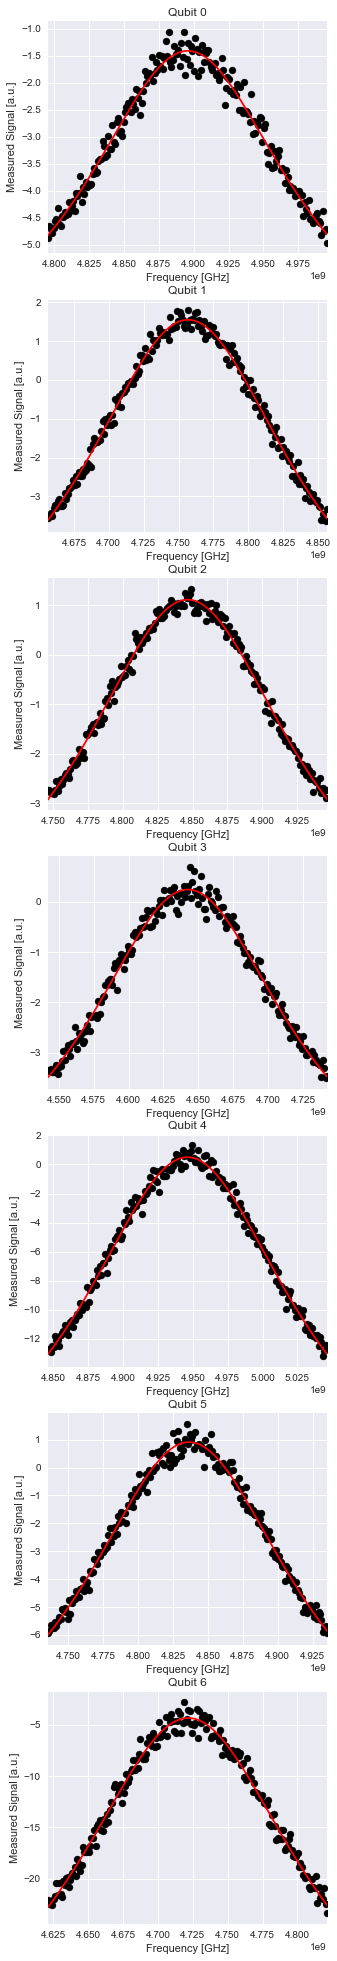

In [96]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

plt.figure(figsize = (5, 5*num_qubit))

pi_freq_12_list = []
for qubit in range(num_qubit):
# for qubit in range(3, 4):

    fit_params, y_fit = fit_function(freq_12_sweep[qubit],
                                    np.real(freq_12_sweep_data[qubit, :]), 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                    [-20, default_qubit_freq_list[qubit] + anharm_12_list[qubit], 0.06*GHz, 3*GHz]
                                    )

    plt.subplot(num_qubit, 1, qubit + 1)
    plt.scatter(freq_12_sweep[qubit], np.real(freq_12_sweep_data[qubit, :]), color='black') # plot real part of sweep values
    plt.xlim([min(freq_12_sweep[qubit]), max(freq_12_sweep[qubit])])
    plt.plot(freq_12_sweep[qubit], y_fit, color='red')

    plt.xlabel("Frequency [GHz]")
    plt.ylabel("Measured Signal [a.u.]")
    
    plt.title(f"Qubit {qubit}")

    A, rough_qubit_frequency, B, C = fit_params
    rough_qubit_frequency = rough_qubit_frequency # make sure qubit freq is in Hz
    print(f"Measured 1->2 pi pulse frequency for qubit {qubit} is {round(rough_qubit_frequency/GHz, 5)} GHz."
          f" Difference from estimate is {round((rough_qubit_frequency - backend_defaults.qubit_freq_est[qubit])/GHz, 5)} GHz")
    pi_freq_12_list.append(rough_qubit_frequency)

# Measure the amplitude of 1 -> 2 $\pi$ pulse

In [33]:
# experimental configuration
num_rabi_points = 200 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [34]:
x12_duration = 160
x12_sigma = 40

qubit_12_freq_list = [backend_defaults.qubit_freq_est[qubit] + backend_properties.qubits[qubit][3].value * GHz for qubit in range(num_qubit)]
rabi_sched_list = []
amp = Parameter('amp')
for qubit in range(num_qubit):
    qubit_12_freq = qubit_12_freq_list[qubit]
    with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(qubit_12_freq, drive_chan)
        pulse.play(pulse.Gaussian(duration=x12_duration,
                                  amp=amp,
                                  sigma=x12_sigma,
                                  name='x12_pulse'), drive_chan)
    rabi_sched_list.append(rabi_sched)

In [8]:
qubit_12_freq_list

[4895494078.715134,
 4756404483.717648,
 4846370740.285762,
 4642167383.268703,
 4946134014.208843,
 4835303234.337177,
 4721137219.19933]

In [35]:
qubit_list = list(range(num_qubit))

rabi_gate = Gate("rabi", 1, [amp])

qc_rabi = QuantumCircuit(num_qubit, num_qubit)

for qubit in qubit_list:
    qc_rabi.x(qubit)
    qc_rabi.append(rabi_gate, [qubit])
    qc_rabi.add_calibration(rabi_gate, (qubit,), rabi_sched_list[qubit], [amp])
qc_rabi.measure(qubit_list, qubit_list)
exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]

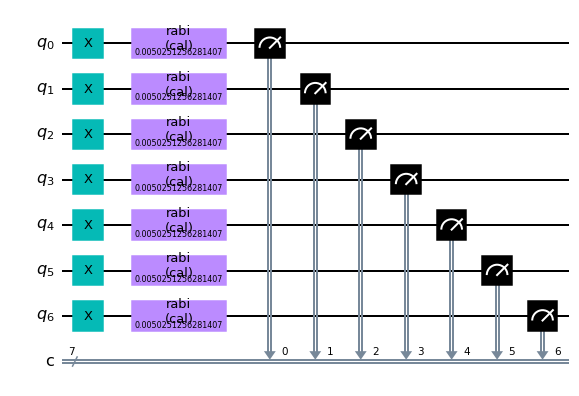

In [10]:
exp_rabi_circs[1].draw()

In [11]:
# rabi_12_job = backend.run(exp_rabi_circs, 
#                           meas_level=1, 
#                           meas_return='avg', 
#                           shots=NUM_SHOTS)
# rabi_12_job.job_id()

'63f4ed4a6fb5c02a16d824fe'

In [12]:
# rabi_12_job = backend.retrieve_job('63f4ed4a6fb5c02a16d824fe')

In [15]:
# save_job(rabi_12_job, filename='data/rabi_12_job.pickle')

In [ ]:
# rabi_12_job = load_job(filename='data/rabi_12_job.pickle')

In [13]:
# from qiskit.tools.monitor import job_monitor

# job_monitor(rabi_12_job)

Job Status: job has successfully run


In [113]:
# # Get the job data (average)
# rabi_12_data = get_job_data(rabi_12_job, average=True, scale_factor=scale_factor)

# # Note: Only real part of data is plotted
# rabi_12_data = np.real(baseline_remove(rabi_12_data, axis=1, reshape=(-1,1)))

# save_job(rabi_12_data, filename='data/rabi_12_job_data.pickle')

In [ ]:
rabi_12_data = load_job("data/rabi_12_job_data.pickle")
rabi_12_data = np.real(baseline_remove(rabi_12_data, axis=1, reshape=(-1,1)))

In [15]:
rabi_12_data.shape

(7, 200)

[0.29402562906024926,
 0.2385730015587484,
 0.2264798172832192,
 0.2930423547839954,
 0.2371687140089449,
 0.26141002803087326,
 0.2907870967241408]

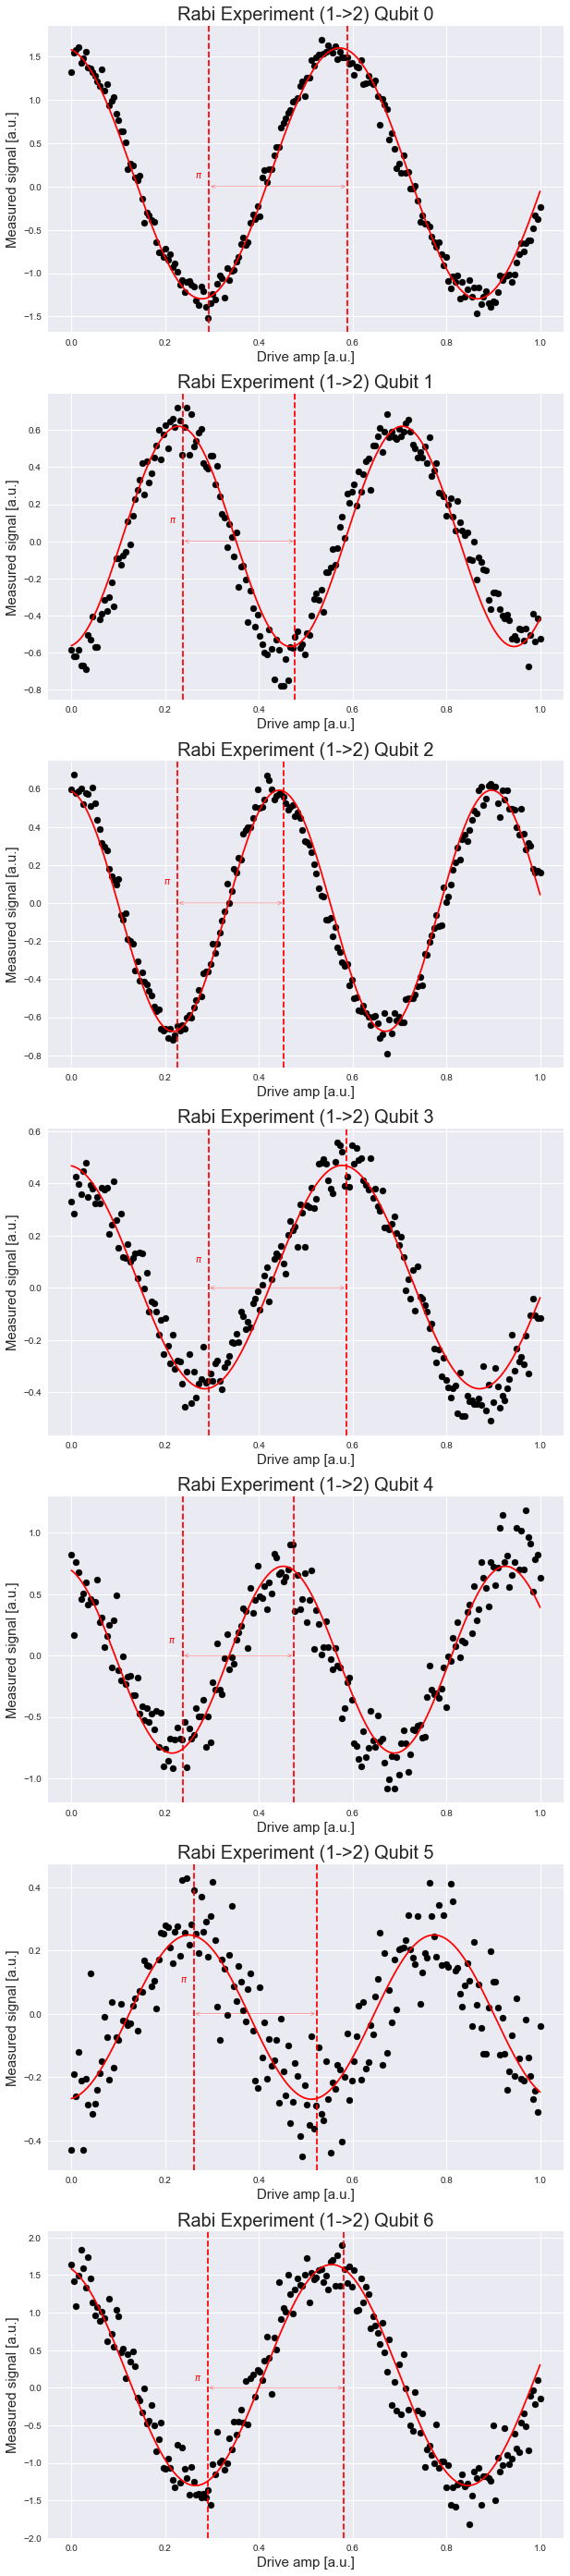

In [114]:
initial_params = [
                    [0.4, 0, 0.55, 0],
                    [1.5, 0, 0.6, 0],
                    [0.6, 0, 0.5, 0],
                    [0.6, 0, 0.5, 0],
                    [0.5, 0, 0.4, 0],
                    [0.4, 0, 0.7, 0],
                    [4, 0, 0.7, 0]
                ]

plt.figure(figsize = (10, 50))

pi_amp_12_list = []
for qubit in range(num_qubit):
    (rabi_12_fit_params, 
     rabi_12_y_fit) = fit_function(drive_amps,
                                   rabi_12_data[qubit], 
                                   lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                                   initial_params[qubit])
    
    plt.subplot(num_qubit, 1, qubit + 1)
    plt.scatter(drive_amps, rabi_12_data[qubit], color='black')
    plt.plot(drive_amps, rabi_12_y_fit, color='red')

    drive_12_period = rabi_12_fit_params[2] 

    pi_amp_12 = drive_12_period/2
    
    pi_amp_12_list.append(pi_amp_12)

    plt.axvline(pi_amp_12, color='red', linestyle='--')
    plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
    plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
    plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

    plt.xlabel("Drive amp [a.u.]", fontsize=15)
    plt.ylabel("Measured signal [a.u.]", fontsize=15)
    plt.title('Rabi Experiment (1->2) Qubit ' + str(qubit), fontsize=20)
pi_amp_12_list

In [9]:
pi_amp_12_list = [0.29402562774644764,
            0.238573001632939,
            0.22647981859358224,
            0.29304235482251545,
            0.23716871367277073,
            0.2614100279623077,
            0.2907870974344614]
pi_amp_12_list

[0.29402562774644764,
 0.238573001632939,
 0.22647981859358224,
 0.29304235482251545,
 0.23716871367277073,
 0.2614100279623077,
 0.2907870974344614]

In [10]:
for qubit in range(num_qubit):
    print(f"Our updated estimate for the 1->2 transition frequency is "
          f"{round(qubit_12_freq_list[qubit]/GHz, 7)} GHz.")
    print(f"Pi Amplitude (1->2) = {pi_amp_12_list[qubit]}")

Our updated estimate for the 1->2 transition frequency is 4.8954941 GHz.
Pi Amplitude (1->2) = 0.29402562774644764
Our updated estimate for the 1->2 transition frequency is 4.7564045 GHz.
Pi Amplitude (1->2) = 0.238573001632939
Our updated estimate for the 1->2 transition frequency is 4.8463707 GHz.
Pi Amplitude (1->2) = 0.22647981859358224
Our updated estimate for the 1->2 transition frequency is 4.6421674 GHz.
Pi Amplitude (1->2) = 0.29304235482251545
Our updated estimate for the 1->2 transition frequency is 4.946134 GHz.
Pi Amplitude (1->2) = 0.23716871367277073
Our updated estimate for the 1->2 transition frequency is 4.8353032 GHz.
Pi Amplitude (1->2) = 0.2614100279623077
Our updated estimate for the 1->2 transition frequency is 4.7211372 GHz.
Pi Amplitude (1->2) = 0.2907870974344614


In [37]:
x12_sched_list = []

for qubit in range(num_qubit):
    qubit_12_freq = qubit_12_freq_list[qubit]
    pi_amp_12 = pi_amp_12_list[qubit]
    with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(qubit_12_freq, drive_chan)
        pulse.play(pulse.Gaussian(duration=x12_duration,
                                  amp=pi_amp_12,
                                  sigma=x12_sigma,
                                  name='x12_pulse'), drive_chan)
    x12_sched_list.append(x12_sched)

# Measure 2 -> 3 frequency

In [75]:
manual_freq_list = [4499763198.374404,
                    4368208449.057032,
                    4450642672.831749,
                    4254579704.142257,
                    4565451719.315841,
                    4439576050.937587,
                    4310346400.634354]

# smaller range sweep
num_freqs = 200
drive_power = 0.15
sweep_freqs = np.linspace(-0.1*GHz, 0.1*GHz, num_freqs)

# there are pulse parameters of the single qubit drive in IBM devices
x23_duration = 160
x23_sigma = 40

In [76]:
freq_sweep_23_list = []
freq23_sweep_sched_list = []
for qubit in range(num_qubit):
    freq_sweep_23 = Parameter(f'freq_sweep_23_{qubit}')
    freq_sweep_23_list.append(freq_sweep_23)
    with pulse.build(backend=backend, default_alignment='sequential', name=f'Frequency sweep 23 {qubit}') as freq23_sweep_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(freq_sweep_23 + manual_freq_list[qubit], drive_chan)
        pulse.play(pulse.Gaussian(duration=x23_duration,
                                  amp=drive_power,
                                  sigma=x23_sigma,
                                  name='x23_pulse'), drive_chan)
    freq23_sweep_sched_list.append(freq23_sweep_sched)

In [77]:
qubit_list = list(range(num_qubit))

qc_spect = QuantumCircuit(num_qubit)

x12_gate = Gate("x12_gate", 1, [])
for qubit in qubit_list:
    qc_spect.x(qubit)
    
    qc_spect.append(x12_gate, [qubit])
    qc_spect.add_calibration(x12_gate, (qubit, ), x12_sched_list[qubit])
    
    spect_gate = Gate("spect", 1, [freq_sweep_23_list[qubit]])
    qc_spect.append(spect_gate, [qubit])
    qc_spect.add_calibration(spect_gate, (qubit, ), freq23_sweep_sched_list[qubit], [freq_sweep_23_list[qubit]])
    
qc_spect.measure_all()
    
exp_spect_circs = [qc_spect.assign_parameters({freq_sweep_23_list[qubit]: f for qubit in qubit_list}) for f in sweep_freqs]

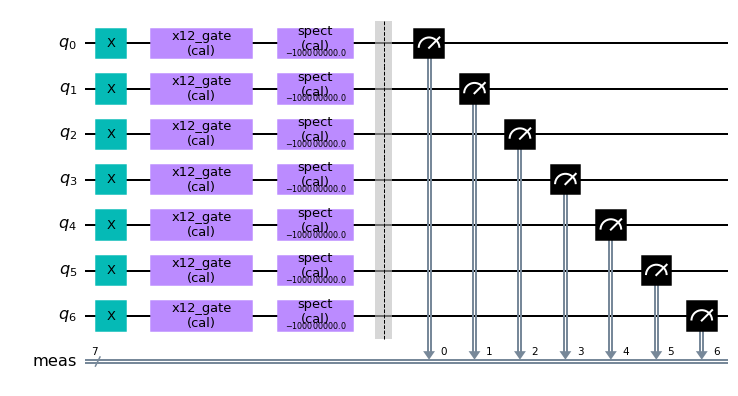

In [82]:
exp_spect_circs[0].draw()

In [16]:
# freq_23_sweep_job = backend.run(exp_spect_circs, 
#                                      meas_level=1, 
#                                      meas_return='avg', 
#                                      shots=NUM_SHOTS)
# freq_23_sweep_job.job_id()

'63f4f0265b887011191e03e2'

In [17]:
# freq_23_sweep_job = backend.retrieve_job('63f4f0265b887011191e03e2')

In [18]:
# save_job(freq_23_sweep_job, filename='data/freq_23_sweep_job.pickle')

In [ ]:
# freq_23_sweep_job = load_job(filename='data/freq_23_sweep_job.pickle')

In [17]:
# from qiskit.tools.monitor import job_monitor

# job_monitor(excited_freq_sweep_job)

Job Status: job has successfully run


In [99]:
# # Get the refined data (average)
# freq_23_sweep_data = get_job_data(freq_23_sweep_job, average=True, scale_factor=scale_factor)
# freq_23_sweep = np.array(manual_freq_list).reshape((7, 1)) + sweep_freqs
# save_job(freq_23_sweep_data, filename='data/freq_23_sweep_job_data.pickle')

In [ ]:
freq_23_sweep_data = load_job("data/freq_23_sweep_job_data.pickle")
freq_23_sweep = np.array(manual_freq_list).reshape((7, 1)) + sweep_freqs

Measured 2->3 pi pulse frequency for qubit 0 is 4.50503 GHz. Difference from estimate is -0.73032 GHz
Measured 2->3 pi pulse frequency for qubit 1 is 4.36434 GHz. Difference from estimate is -0.73532 GHz
Measured 2->3 pi pulse frequency for qubit 2 is 4.45645 GHz. Difference from estimate is -0.73185 GHz
Measured 2->3 pi pulse frequency for qubit 3 is 4.24835 GHz. Difference from estimate is -0.73912 GHz
Measured 2->3 pi pulse frequency for qubit 4 is 4.55946 GHz. Difference from estimate is -0.72591 GHz
Measured 2->3 pi pulse frequency for qubit 5 is 4.44574 GHz. Difference from estimate is -0.73035 GHz
Measured 2->3 pi pulse frequency for qubit 6 is 4.32592 GHz. Difference from estimate is -0.73798 GHz


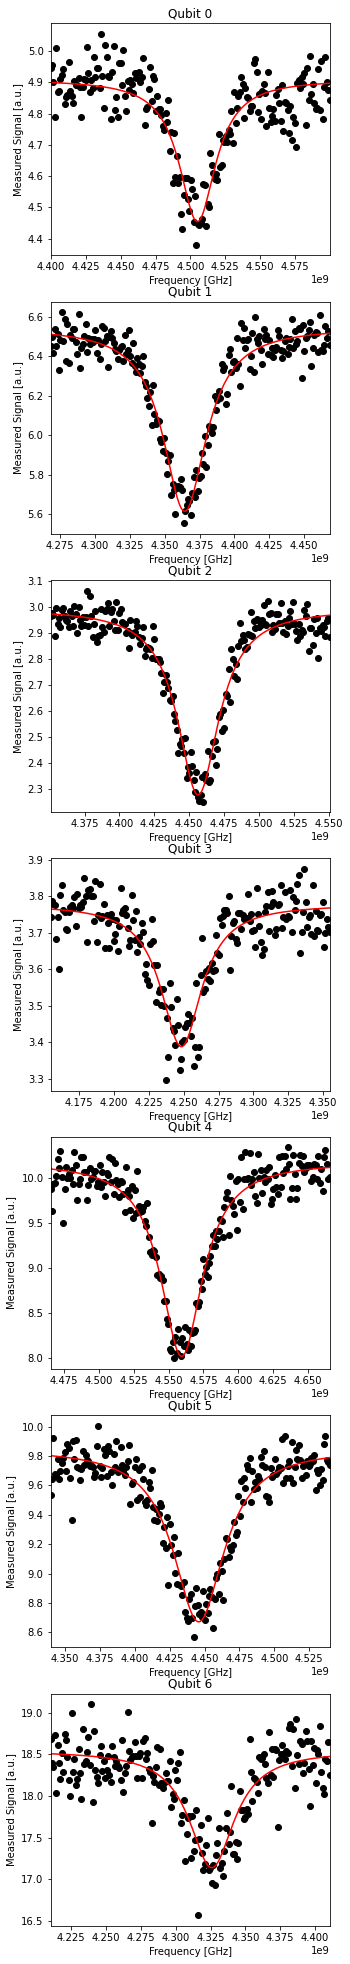

In [89]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

plt.figure(figsize = (5, 5*num_qubit))

pi_freq_23_list = []
for qubit in range(num_qubit):
# for qubit in range(3, 4):

    fit_params, y_fit = fit_function(freq_23_sweep[qubit],
                                     np.real(freq_23_sweep_data[qubit, :]), 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-20, manual_freq_list[qubit], 0.06*GHz, 3*GHz]
                                    )

    plt.subplot(num_qubit, 1, qubit + 1)
    plt.scatter(freq_23_sweep[qubit], np.real(freq_23_sweep_data[qubit, :]), color='black') # plot real part of sweep data
    plt.xlim([min(freq_23_sweep[qubit]), max(freq_23_sweep[qubit])])
    plt.plot(freq_23_sweep[qubit], y_fit, color='red')

    plt.xlabel("Frequency [GHz]")
    plt.ylabel("Measured Signal [a.u.]")
    
    plt.title(f"Qubit {qubit}")

    A, rough_qubit_frequency, B, C = fit_params
    rough_qubit_frequency = rough_qubit_frequency # make sure qubit freq is in Hz
    print(f"Measured 2->3 pi pulse frequency for qubit {qubit} is {round(rough_qubit_frequency/GHz, 5)} GHz."
          f" Difference from estimate is {round((rough_qubit_frequency - backend_defaults.qubit_freq_est[qubit])/GHz, 5)} GHz")
    pi_freq_23_list.append(rough_qubit_frequency)

In [46]:
pi_freq_23_list

[4505870423.558304,
 4362524860.86402,
 4461907524.020117,
 4235116493.9114137,
 4552109996.59541,
 4443926589.868059,
 4320528956.502897]

# Measure the amplitude of 2 -> 3 $\pi$ pulse

In [51]:
# experimental configuration
num_rabi_points = 200 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [52]:
x23_duration = 160
x23_sigma = 40

qubit_23_freq_list = pi_freq_23_list
rabi_sched_list = []
amp = Parameter('amp')
for qubit in range(num_qubit):
    qubit_23_freq = qubit_23_freq_list[qubit]
    with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(qubit_23_freq, drive_chan)
        pulse.play(pulse.Gaussian(duration=x23_duration,
                                  amp=amp,
                                  sigma=x23_sigma,
                                  name='x23_pulse'), drive_chan)
    rabi_sched_list.append(rabi_sched)

In [53]:
qubit_list = list(range(num_qubit))

x12_gate = Gate("x12_gate", 1, [])
rabi_gate = Gate("rabi", 1, [amp])

qc_rabi = QuantumCircuit(num_qubit, num_qubit)

for qubit in qubit_list:
    qc_rabi.x(qubit)
    
    qc_rabi.append(x12_gate, [qubit])
    qc_rabi.add_calibration(x12_gate, (qubit, ), x12_sched_list[qubit])
    
    qc_rabi.append(rabi_gate, [qubit])
    qc_rabi.add_calibration(rabi_gate, (qubit,), rabi_sched_list[qubit], [amp])
    
qc_rabi.measure(qubit_list, qubit_list)

exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]

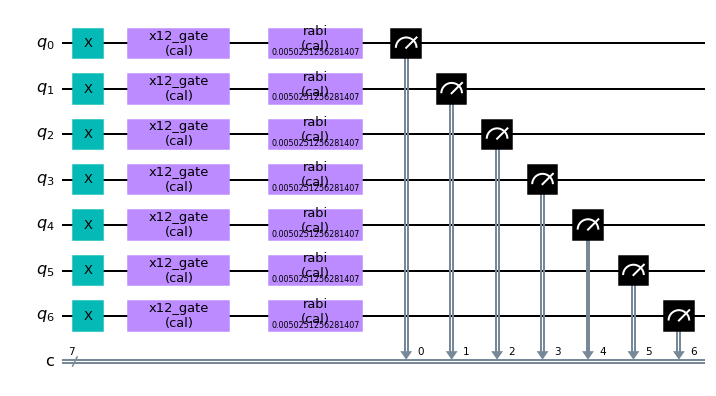

In [54]:
exp_rabi_circs[1].draw()

In [55]:
# rabi_23_job = backend.run(exp_rabi_circs, 
#                           meas_level=1, 
#                           meas_return='avg', 
#                           shots=NUM_SHOTS)
# rabi_23_job.job_id()

'63f4f4d25ddc101cb9307ca7'

In [19]:
# rabi_23_job = backend.retrieve_job('63f4f4d25ddc101cb9307ca7')

In [20]:
# save_job(rabi_23_job, filename='data/rabi_23_job.pickle')

In [ ]:
# rabi_23_job = load_job(filename='data/rabi_23_job.pickle')

In [57]:
# from qiskit.tools.monitor import job_monitor

# job_monitor(rabi_23_job)

Job Status: job has successfully run


In [103]:
# # Get the job data (average)
# rabi_23_data = get_job_data(rabi_23_job, average=True, scale_factor=scale_factor)
# # Note: Only real part of data is plotted
# rabi_23_data = np.real(baseline_remove(rabi_23_data, axis=1, reshape=(-1,1)))

# save_job(rabi_23_data, filename='data/rabi_23_job_data.pickle')

In [ ]:
# Get the job data (average)
rabi_23_data = load_job("data/rabi_23_job_data.pickle")
# Note: Only real part of data is plotted
rabi_23_data = np.real(baseline_remove(rabi_23_data, axis=1, reshape=(-1,1)))

In [104]:
rabi_23_data.shape

(7, 200)

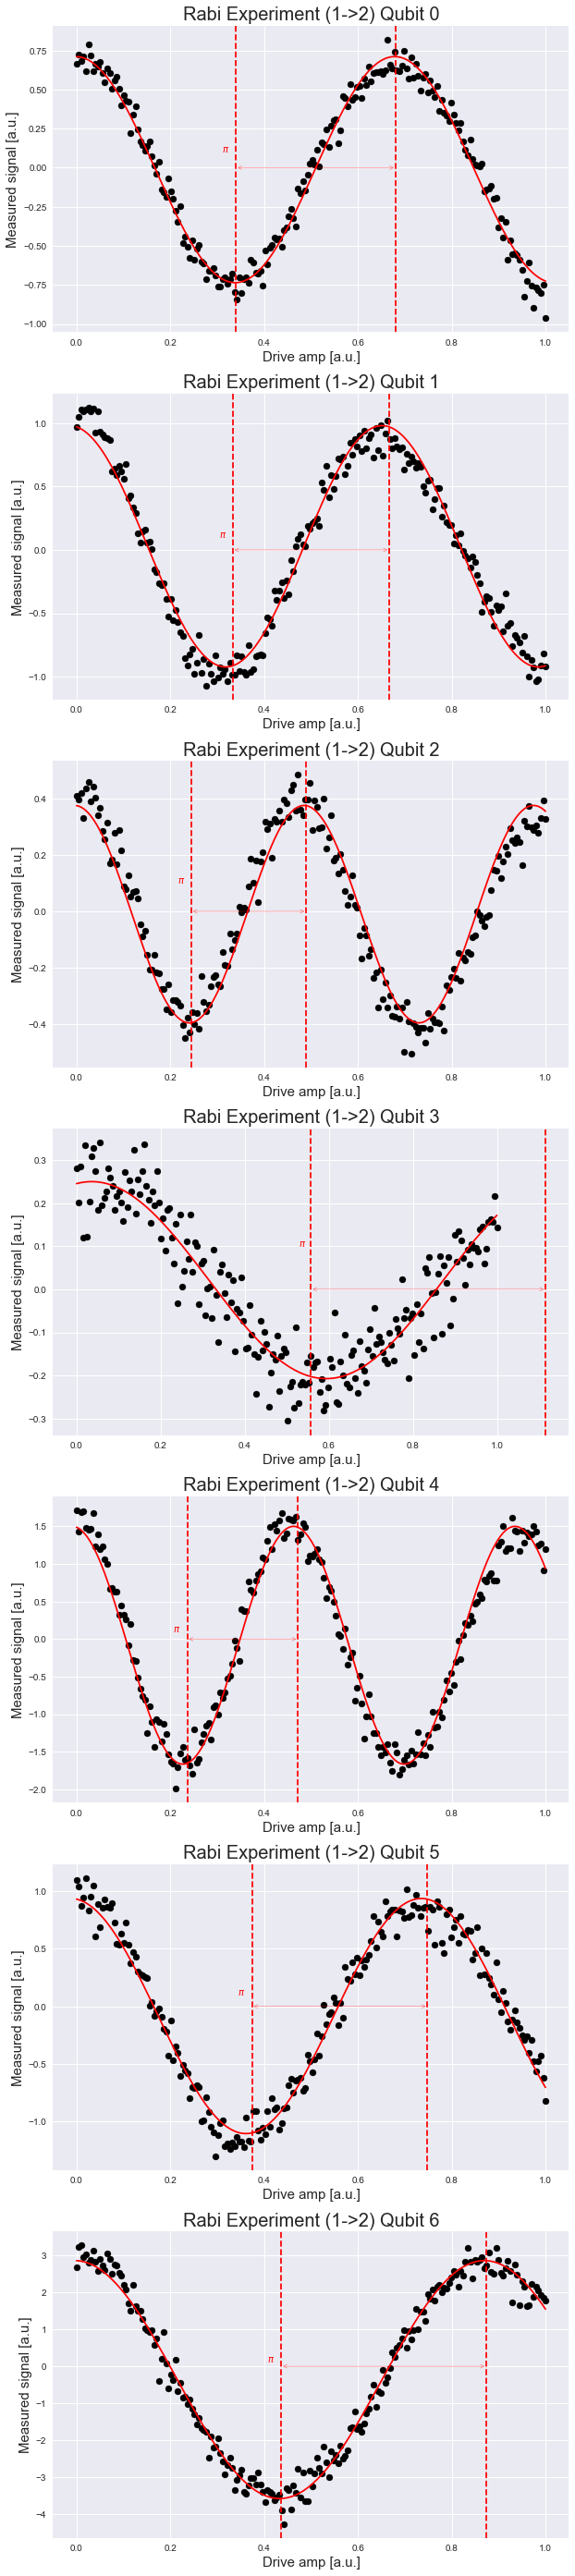

In [110]:
initial_params = [
                    [0.4, 0, 0.55, 0],
                    [1.5, 0, 0.6, 0],
                    [0.4, 0, 0.35, 0],
                    [0.3, 0, 1.2, 0],
                    [0.5, 0, 0.4, 0],
                    [0.4, 0, 0.7, 0],
                    [4, 0, 0.7, 0]
                ]

plt.figure(figsize = (10, 50))

pi_amp_23_list = []
for qubit in range(num_qubit):
    (rabi_23_fit_params, 
     rabi_23_y_fit) = fit_function(drive_amps,
                                   rabi_23_data[qubit], 
                                   lambda x, A, B, drive_23_period, phi: (A*np.cos(2*np.pi*x/drive_23_period - phi) + B),
                                   initial_params[qubit])
    
    plt.subplot(num_qubit, 1, qubit + 1)
    plt.scatter(drive_amps, rabi_23_data[qubit], color='black')
    plt.plot(drive_amps, rabi_23_y_fit, color='red')

    drive_23_period = rabi_23_fit_params[2] 

    pi_amp_23 = drive_23_period/2
    
    pi_amp_23_list.append(pi_amp_23)

    plt.axvline(pi_amp_23, color='red', linestyle='--')
    plt.axvline(pi_amp_23+drive_23_period/2, color='red', linestyle='--')
    plt.annotate("", xy=(pi_amp_23+drive_23_period/2, 0), xytext=(pi_amp_23,0), arrowprops=dict(arrowstyle="<->", color='red'))
    plt.annotate("$\pi$", xy=(pi_amp_23-0.03, 0.1), color='red')

    plt.xlabel("Drive amp [a.u.]", fontsize=15)
    plt.ylabel("Measured signal [a.u.]", fontsize=15)
    plt.title('Rabi Experiment (1->2) Qubit ' + str(qubit), fontsize=20)

# Final Results

In [62]:
qubit_12_freq_list

[4895494078.715134,
 4756404483.717648,
 4846370740.285762,
 4642167383.268703,
 4946134014.208843,
 4835303234.337177,
 4721137219.19933]

In [63]:
pi_amp_12_list

[0.29402562774644764,
 0.238573001632939,
 0.22647981859358224,
 0.29304235482251545,
 0.23716871367277073,
 0.2614100279623077,
 0.2907870974344614]

In [64]:
pi_freq_23_list

[4505870423.558304,
 4362524860.86402,
 4461907524.020117,
 4235116493.9114137,
 4552109996.59541,
 4443926589.868059,
 4320528956.502897]

In [65]:
pi_amp_23_list

[0.3399681752764203,
 0.33337488348099936,
 0.2446224536938508,
 0.557805814996629,
 0.23597343421038736,
 0.3740496942589511,
 0.43668659735526755]

In [102]:
x23_duration = 160
x23_sigma = 40

qubit_23_freq_list = pi_freq_23_list
x23_sched_list = []
amp = Parameter('amp')
for qubit in range(num_qubit):
    qubit_23_freq = qubit_23_freq_list[qubit]
    pi_amp_23 = pi_amp_23_list[qubit]
    with pulse.build(backend=backend, default_alignment='sequential', name='x23 schedule') as x23_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(qubit_23_freq, drive_chan)
        pulse.play(pulse.Gaussian(duration=x23_duration,
                                  amp=pi_amp_23,
                                  sigma=x23_sigma,
                                  name='x23_pulse'), drive_chan)
    x23_sched_list.append(x23_sched)

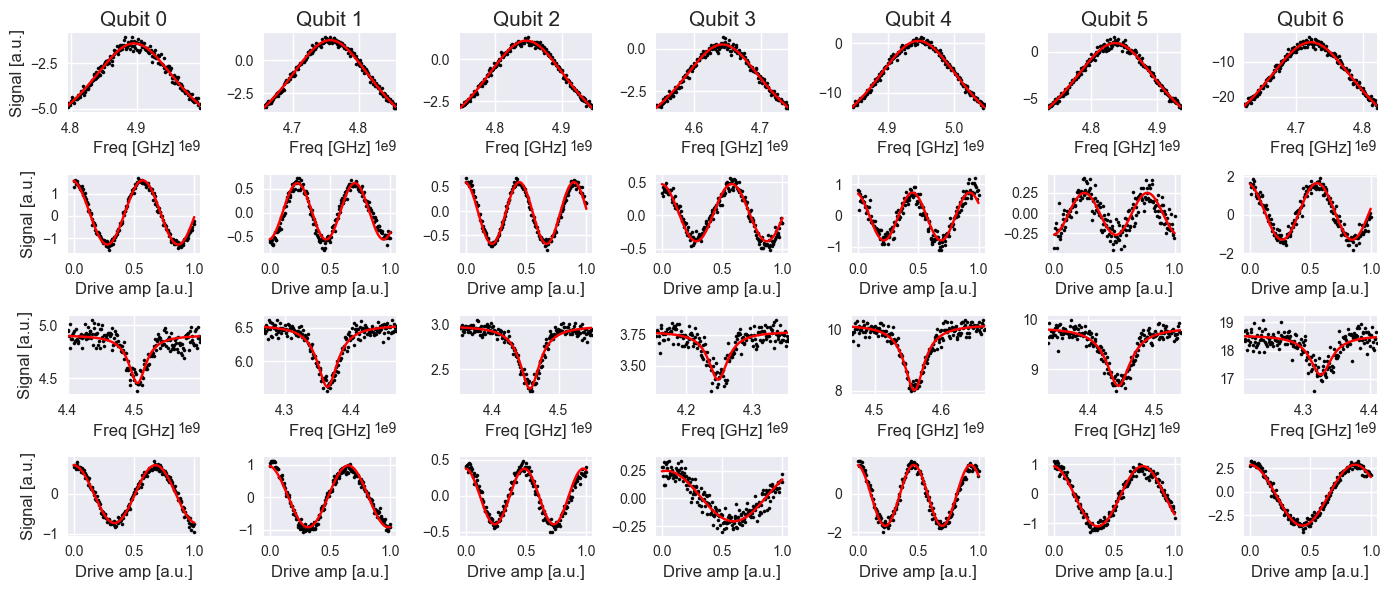

In [120]:
# # Note: Only real part of data is plotted
# rabi_12_data = np.real(baseline_remove(rabi_12_data, axis))

mpl.style.use('seaborn')

fig, axes = plt.subplots(4, 7, figsize = (14, 6), dpi = 100)

fontsize = 12

for qubit in range(num_qubit):
    # Freq
    fit_params, y_fit = fit_function(freq_12_sweep[qubit],
                                     np.real(freq_12_sweep_data[qubit, :]), 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-20, default_qubit_freq_list[qubit] + anharm_12_list[qubit], 0.06*GHz, 3*GHz]
                                    )

    # plt.subplot(num_qubit, 1, qubit + 1)
    axes[0][qubit].scatter(freq_12_sweep[qubit], np.real(freq_12_sweep_data[qubit, :]), color='black', s = 5) # plot real part of sweep data
    axes[0][qubit].set_xlim([min(freq_12_sweep[qubit]), max(freq_12_sweep[qubit])])
    axes[0][qubit].plot(freq_12_sweep[qubit], y_fit, color='red')

    axes[0][qubit].set_xlabel("Freq [GHz]", fontsize=fontsize)
    if qubit == 0:
        axes[0][qubit].set_ylabel("Signal [a.u.]", fontsize=fontsize)
    axes[0][qubit].set_title(f'Qubit {qubit}', fontsize=15)
    
    # axes[0][qubit].set_title(f"Qubit {qubit}")


initial_params = [
                    [0.4, 0, 0.55, 0],
                    [1.5, 0, 0.6, 0],
                    [0.6, 0, 0.5, 0],
                    [0.6, 0, 0.5, 0],
                    [0.5, 0, 0.4, 0],
                    [0.4, 0, 0.7, 0],
                    [4, 0, 0.7, 0]
                ]

for qubit in range(num_qubit):
    (rabi_12_fit_params, 
     rabi_12_y_fit) = fit_function(drive_amps,
                                   rabi_12_data[qubit], 
                                   lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                                   initial_params[qubit])
    
    # plt.subplot(num_qubit, 1, qubit + 1)
    axes[1][qubit].scatter(drive_amps, rabi_12_data[qubit], color='black', s = 5)
    axes[1][qubit].plot(drive_amps, rabi_12_y_fit, color='red')

    drive_12_period = rabi_12_fit_params[2] 

    pi_amp_12 = drive_12_period/2
    
    pi_amp_12_list.append(pi_amp_12)

    # axes[qubit].axvline(pi_amp_12, color='red', linestyle='--')
    # axes[qubit].axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
    # axes[qubit].annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
    # axes[qubit].annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')
    if qubit == 0:
        axes[1][qubit].set_ylabel("Signal [a.u.]", fontsize=fontsize)
    axes[1][qubit].set_xlabel("Drive amp [a.u.]", fontsize=fontsize)



for qubit in range(num_qubit):
    # Freq
    fit_params, y_fit = fit_function(freq_23_sweep[qubit],
                                     np.real(freq_23_sweep_data[qubit, :]), 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-20, manual_freq_list[qubit], 0.06*GHz, 3*GHz]
                                    )

    # plt.subplot(num_qubit, 1, qubit + 1)
    axes[2][qubit].scatter(freq_23_sweep[qubit], np.real(freq_23_sweep_data[qubit, :]), color='black', s = 5) # plot real part of sweep data
    axes[2][qubit].set_xlim([min(freq_23_sweep[qubit]), max(freq_23_sweep[qubit])])
    axes[2][qubit].plot(freq_23_sweep[qubit], y_fit, color='red')

    axes[2][qubit].set_xlabel("Freq [GHz]", fontsize=fontsize)
    if qubit == 0:
        axes[2][qubit].set_ylabel("Signal [a.u.]", fontsize=fontsize)
    
    # axes[2][qubit].set_title(f"Qubit {qubit}")



initial_params = [
                    [0.4, 0, 0.55, 0],
                    [1.5, 0, 0.6, 0],
                    [0.4, 0, 0.35, 0],
                    [0.3, 0, 1.2, 0],
                    [0.5, 0, 0.4, 0],
                    [0.4, 0, 0.7, 0],
                    [4, 0, 0.7, 0]
                ]
for qubit in range(num_qubit):
    (rabi_23_fit_params, 
     rabi_23_y_fit) = fit_function(drive_amps,
                                   rabi_23_data[qubit], 
                                   lambda x, A, B, drive_23_period, phi: (A*np.cos(2*np.pi*x/drive_23_period - phi) + B),
                                   initial_params[qubit])
    axes[3][qubit].scatter(drive_amps, rabi_23_data[qubit], color='black', s = 5)
    axes[3][qubit].plot(drive_amps, rabi_23_y_fit, color='red')

    drive_23_period = rabi_23_fit_params[2] 

    pi_amp_23 = drive_23_period/2

    axes[3][qubit].set_xlabel("Drive amp [a.u.]", fontsize=fontsize)
    if qubit == 0:
        axes[3][qubit].set_ylabel("Signal [a.u.]", fontsize=fontsize)

plt.tight_layout()

# plt.savefig("./figs/calibration.pdf")
